### Fine tuning the fine tune

This notebook will walk through the steps to customize the [stable-diffusion-inpainting](https://huggingface.co/runwayml/stable-diffusion-inpainting) model from runwayml.

In [75]:
!git clone https://github.com/lrav35/diffusion.git

Cloning into 'diffusion'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 229 (delta 13), reused 122 (delta 13), pack-reused 105
Receiving objects: 100% (229/229), 89.98 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
!pip install -r diffusion/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [74]:
# delete and reclone if updates are made
!rm -rf diffusion

In [41]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
from io import BytesIO
import requests
import os
import uuid

from huggingface_hub import snapshot_download
from diffusers import StableDiffusionInpaintPipeline
import torch

In [23]:
def display_image_grid(images, reduction_factor=0.5, square=False, save=False):
  if square: imgs = [img.resize((256, 256)) for img in images]
  imgs = [img.resize((int(img.size[0]*reduction_factor), int(img.size[1]*reduction_factor))) for img in images]
  grid_shape = (1,len(images))
  w, h = imgs[0].size
  rows, cols = grid_shape[0], grid_shape[1]
  grid = Image.new("RGB", size=(cols * w, rows * h))
  for i, image in enumerate(imgs):
    grid.paste(image, box=(i % cols * w, i // cols * h))
  return grid

First, we are going to teach our model about my cat, Stella! We will fine tune the inpainting model on six images of her and gain the ability to put her in different settings. Sure, stable diffusion could generate a cat, but it wouldn't be the real Stella. Let's see how this goes.

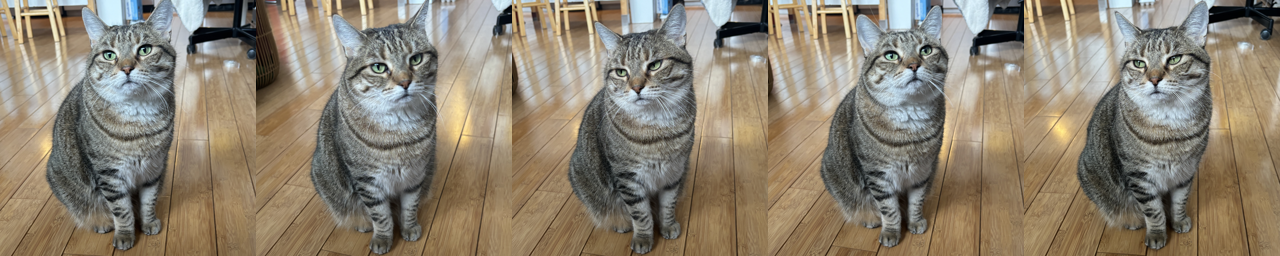

In [6]:
path = "diffusion/stella/*.JPG"
images = [Image.open(pth) for pth in glob.glob(path)]

display_image_grid(images)

But first, let's see what the model can do first before fine tuning.

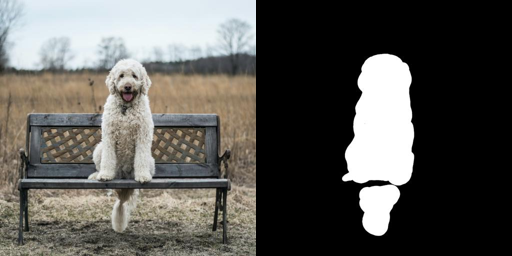

In [20]:
def download_image(url, dir, name):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB").resize((512,512))
    if not os.path.exists(dir):
        os.makedirs(dir) # Create directory if it doesn't exist
    image_path = os.path.join(dir, name)
    image.save(image_path)
    return image_path

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = download_image(img_url, "diffusion/test_images", "dog_on_bench.jpeg")
mask_image = download_image(mask_url, "diffusion/test_masks", "bench_mask.jpeg")
images = [image, mask_image]
display_image_grid([Image.open(image) for image in images])

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt = "a cartoon bird sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0)

image = Image.open(image)
mask_image = Image.open(mask_image)

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

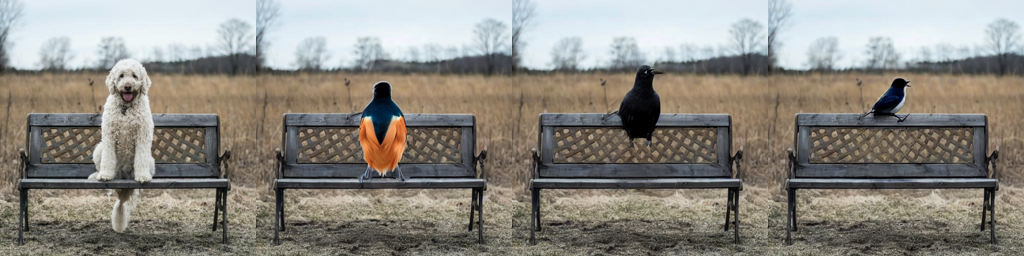

In [ ]:
images.insert(0, image)
display_image_grid(images, 1, num_samples + 1)

## Model Training

In [ ]:
# run if GPU VRAM has data on it from a previous run
torch.cuda.empty_cache()

In [ ]:
 # TODO: add wandb loss plot

In [7]:
!accelerate launch diffusion/fine_tune_dreambooth.py \
              --prompt="a photo of stella the cat" \
              --input_data_dir="diffusion/stella/" \
              --max_train_steps=500 \
              --train_batch_size=1

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-04-05 11:58:23.456006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 11:58:23.456058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 11:58:23.457539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

How did it work? Let's try some generations

In [8]:
# Load the pretrained model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "diffusion-inpainting",
    torch_dtype=torch.float16
)
pipe.to('cuda')


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [106]:
def generate_and_save_images(image_and_mask, subdir, pipe, prompt, original=False, resize_sz=None):
  image = Image.open(image_and_mask[0])
  mask = Image.open(image_and_mask[1])
  if resize_sz:
    image = image.resize(resize_sz).convert('RGB')
    mask = mask.resize(resize_sz).convert('RGB')
  images = pipe(prompt=[prompt]*4, image=image, mask_image=mask).images
  dir = f"diffusion/generated/{subdir}"
  if not os.path.exists(dir): os.makedirs(dir) # Create directory if it doesn't exist
  for i, img in enumerate(images):
    name = str(uuid.uuid4())
    img.save(f'{dir}{name}.jpg')
  if original: images.insert(0, image) # insert original for comparison
  return display_image_grid(images)



  0%|          | 0/50 [00:00<?, ?it/s]

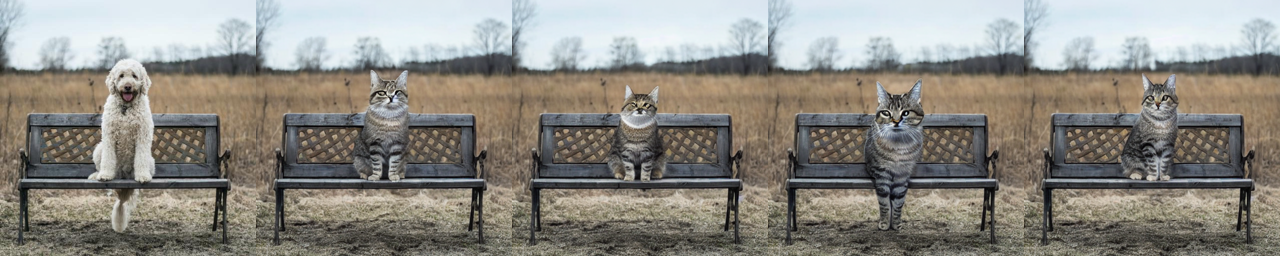

In [56]:
dir = "diffusion/test_images/"
subdir = "bench/"
bench_images = [f"{dir}dog_on_bench.jpeg", f"{dir}/bench_mask.jpeg"]
generate_and_save_images(bench_images, subdir, pipe, "a photo of stella the cat", True)

  0%|          | 0/50 [00:00<?, ?it/s]

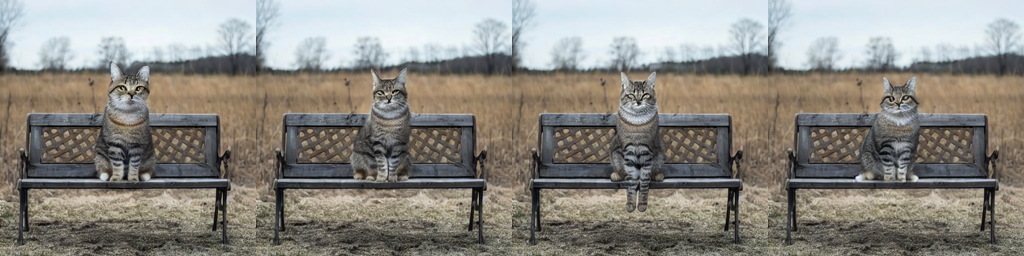

In [58]:
# more samples
generate_and_save_images(bench_images, subdir, pipe, "a photo of stella the cat")

Stella! kind of..

How does the model do with other images? Like Godzilla??

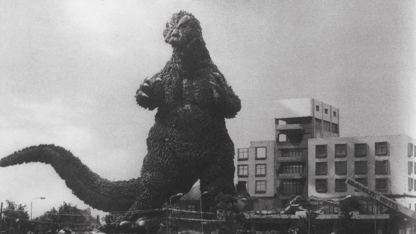

In [40]:
display_image_grid([Image.open("diffusion/test_images/godzilla.jpeg")], 0.1)

  0%|          | 0/50 [00:00<?, ?it/s]

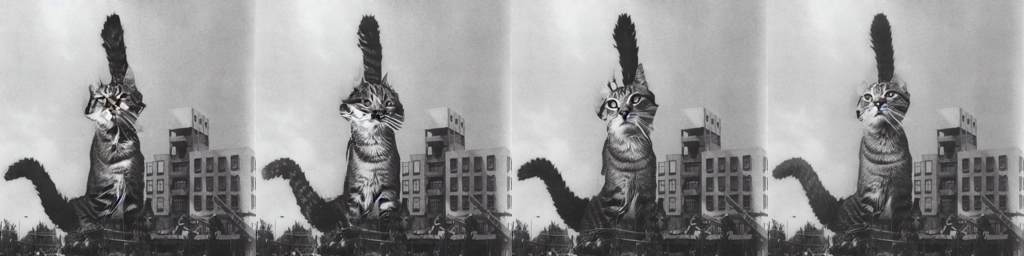

In [64]:
dir = "diffusion/"
subdir = "godzilla/"
godzilla_images = [f"{dir}test_images/godzilla.jpeg", f"{dir}test_masks/godzilla_mask.jpeg"]
generate_and_save_images(godzilla_images, subdir, pipe, "a photo of stella the cat")

Or with King Kong??

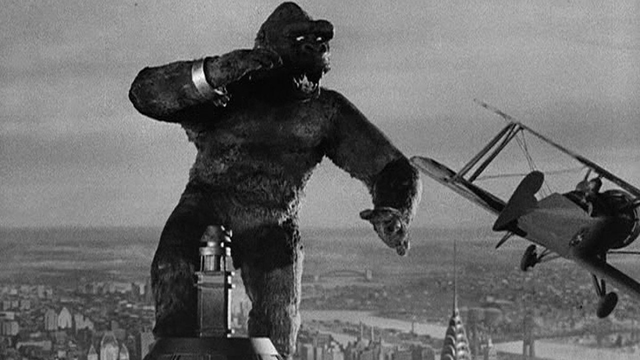

In [67]:
display_image_grid([Image.open("diffusion/test_images/kong.jpeg")], 0.5)

  0%|          | 0/50 [00:00<?, ?it/s]

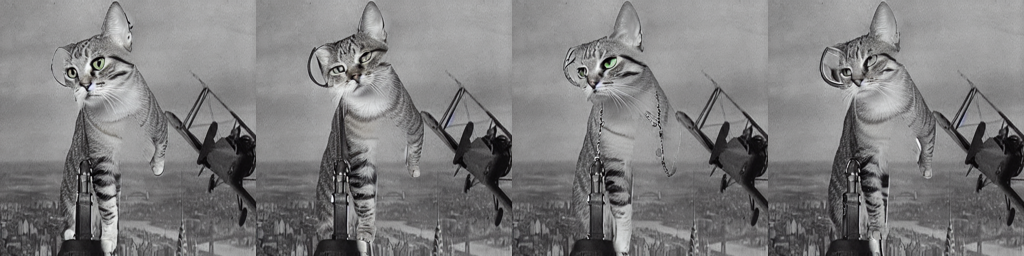

In [71]:
dir = "diffusion/"
subdir = "kong/"
kong_images = [f"{dir}test_images/kong.jpeg", f"{dir}test_masks/kong_mask.jpeg"]
generate_and_save_images(kong_images, subdir, pipe, "a photo of stella the cat")

## e-commerce

Another really prominant use case for diffusoin models is e-commerce. The ability for a model to learn what your products look like is very valuable. Instead of expensive product photoshoots, diffusion opens the possibility for clothing models to wear different clothes. There are also virtual try-on capabilities for consumers online that want to see what they look like with a article of clothing on that they do not physically have. Let's train a model for the ability to change a hat you are wearing to a differnt sports team and color.

In [78]:
torch.cuda.empty_cache()

In [79]:
!accelerate launch diffusion/fine_tune_dreambooth.py \
              --prompt="a photo of a redsox hat" \
              --input_data_dir="diffusion/hats/" \
              --max_train_steps=500 \
              --train_batch_size=1

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-04-05 13:29:50.988132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 13:29:50.988199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 13:29:50.989570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

In [ ]:
# the GPUs I am using dont have a ton of space :(
torch.cuda.empty_cache()

In [ ]:
# Load the pretrained model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "diffusion-inpainting",
    torch_dtype=torch.float16
)
pipe.to('cuda')

Let's see what our new model can do. Can it replace Jay-Z's hat?

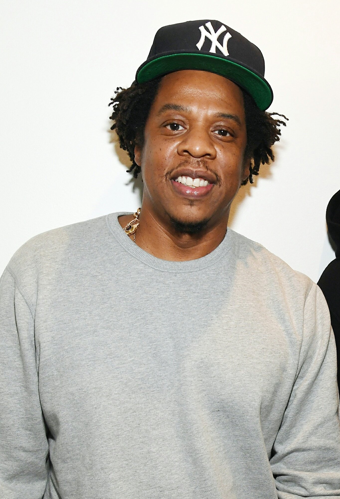

In [82]:
display_image_grid([Image.open("diffusion/test_images/jayz.jpeg")], 0.25)

  0%|          | 0/50 [00:00<?, ?it/s]

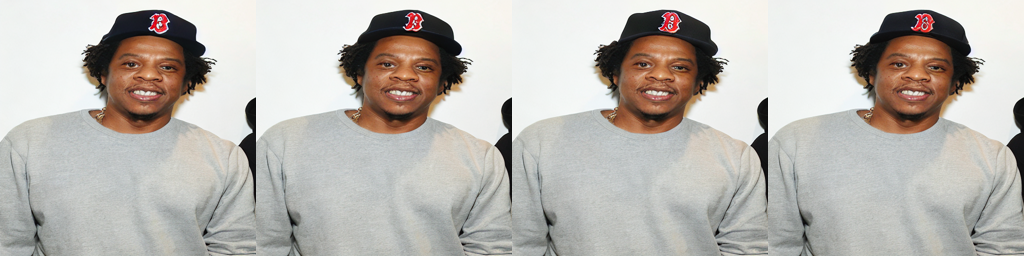

In [107]:
dir = "diffusion/"
subdir = "hats/"
jayz_images = [f"{dir}test_images/jayz.jpeg", f"{dir}test_masks/jayz_mask.jpeg"]
generate_and_save_images(jayz_images, subdir, pipe, "a photo of a redsox hat")

Or can we replace the hat on this model on a website selling hats?

In [102]:
display_image_grid([Image.open("diffusion/test_images/yankees_ecommerce.jpeg")], 0.25)
print(Image.open("diffusion/test_images/yankees_ecommerce.jpeg").size)
print(Image.open("diffusion/test_masks/yankees_ecommerce_mask.jpeg").size)

(1756, 1126)
(1756, 1126)


  0%|          | 0/50 [00:00<?, ?it/s]

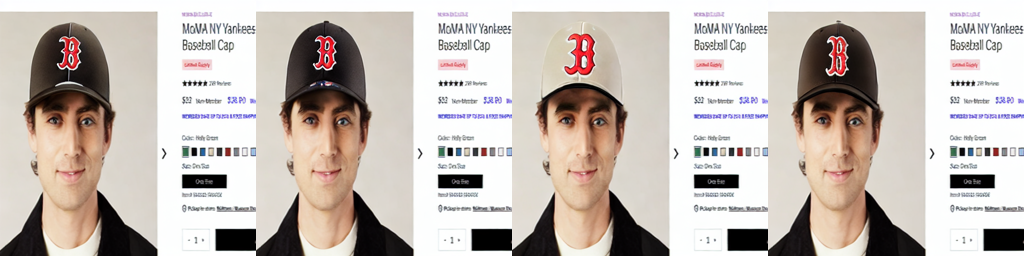

In [112]:
dir = "diffusion/"
subdir = "hats/"
ecommerce_images = [f"{dir}test_images/yankees_ecommerce.jpeg", f"{dir}test_masks/yankees_ecommerce_mask.jpeg"]
generate_and_save_images(ecommerce_images, subdir, pipe, "a photo of a redsox hat", resize_sz=(256,420))

Works pretty well! interesting that the model sometimes makes the hat white despite the all training images being blue hats

In [ ]:
from google.colab import files
!zip -r ./diffusion/generated.zip ./diffusion/generated
files.download("./diffusion/generated.zip")

TODO:
*  Do i need a loss plot? it might not provide any info
* eval metrics? kind of subjective